# Лабораторная работа 4: Семантическая сегментация с использованием PyTorch

## Цели работы

Цель — разработать и обучить сверточную нейронную сеть для задачи мультиклассовой семантической сегментации изображений на наборе данных [SUIM](https://www.kaggle.com/datasets/ashish2001/semantic-segmentation-of-underwater-imagery-suim) с использованием PyTorch.

## Набор данных.

1. Данные содержат 8 классов. Маска сегментации имеет вид трехканального изображения с пикселями, значения которых равно либо 0, либо 255, например, (0, 0, 0), (0, 0, 255) и так далее. Помимо этого встречаются и промежуточные значения, отличные от 0 и 255. В рамках данной лабораторной работы предлагается следующее преобразование: значения маски, меньшие 128, нужно установить в 0, а значения, равные или больше 128, установить в 255.

2. Для упрощения работы рекомендуется объединить следующие классы в один:
- класс 2 - Aquatic plants and sea-grass
- класс 3 - Wrecks and ruins
- класс 5 - Reefs and invertebrates
- класс 7 - Sea-floor and rocks

##  Требования

1. Необходимо выполнить и отобразить в Jupyter следующие задачи:

	- Загрузка и проверка данных. Загрузить и предобработать данные с демонстрацией избранных изображений и соответствующих масок, чтобы подтвердить корректность загрузки и соответствие размерностей данных.
	- Реализация архитектуры сети. Разработать архитектуру нейронной сети для сегментации с использованием фреймворка PyTorch.
	- Настройка гиперпараметров обучения. Настроить параметры обучения, такие как функция ошибки, размер сети, скорость обучения и другие параметры.
	- Тестирование модели. После завершения обучения для оценки качества работы необходимо посчитать accuracy, [IoU](https://lightning.ai/docs/torchmetrics/latest/segmentation/mean_iou.html) и визуализировать [confusion matrix](https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html) (с нормализацией, ```normalize='true'```).
	- Визуализация результатов. После завершения обучения построить и отобразить результаты сегментации на тестовых изображениях, сравнивая с реальными масками сегментации.

2. Выбор архитектуры:
  - Можно использовать или адаптировать известные архитектуры глубокого обучения.
  - Может быть полезным:
    - уменьшить количество параметров в нейронной сети и размер входного изображения для ускорения сходимости, предотвращения переобучения и ускорения работы нейронной сети.
    - использовать аугментацию данных и взвешенные/специализированные функции ошибки. При аугментации данных необходимо учитывать связь изображений с маской классов.
  - Использовать перенос знаний недопустимо.

In [142]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix
import seaborn as sea

import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import numpy as np
import time

Загрузка и проверка корректности данных

In [ ]:
import os
import shutil

from google.colab import drive
drive.mount('/content/drive')

def copy_files_recursive(source_folder, destination_folder):
    for root, dirs, files in os.walk(source_folder):
        for file in files:
            source_path = os.path.join(root, file)
            destination_path = os.path.join(destination_folder, os.path.relpath(source_path, source_folder))

            os.makedirs(os.path.dirname(destination_path), exist_ok=True)

            shutil.copyfile(source_path, destination_path)

Mounted at /content/drive


In [ ]:
remote_root = '/content/drive/MyDrive/SUIM'
root = '/content/SUIM'
copy_files_recursive(remote_root, root)

In [ ]:
number_classes = 5

classes = {
    "background": [(0, 0, 0)],
    "human_divers": [(0, 0, 1)],
    "robots": [(1, 0, 0)],
    "fish_vertebrates": [(1, 1, 0)],
    "other": [(0, 1, 0), (0, 1, 1), (1, 0, 1), (1, 1, 1)]
}

color_classes = [[0, 0, 0],
                 [0, 0, 1],
                 [1, 0, 0],
                 [1, 1, 0],
                 [0, 1, 0]]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, masks):
        self.images = torch.tensor(images, dtype = torch.float)
        self.masks = torch.tensor(masks, dtype = torch.float)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        return image, mask


def load_dataset(root_images, root_masks, image_size):
    images = []
    list_dir = sorted(os.listdir(root_images))
    for file_name in list_dir:
        file_path = os.path.join(root_images, file_name)
        if os.path.isfile(file_path):
            with Image.open(file_path) as image:
                resized_image = np.array(image.resize(image_size)) / 255
                images.append(resized_image)

    labels = []
    list_dir = sorted(os.listdir(root_masks))
    for file_name in list_dir:
        file_path = os.path.join(root_masks, file_name)
        if os.path.isfile(file_path):
            with Image.open(file_path) as mask:
                background = np.zeros(image_size)
                human_divers = np.zeros(image_size)
                robots = np.zeros(image_size)
                fish_vertebrates = np.zeros(image_size)
                other = np.zeros(image_size)

                resized_mask = np.array(mask.resize(image_size)) / 255
                resized_mask = np.where(resized_mask < 0.5, 0, 1)

                for i in range(image_size[0]):
                    for j in range(image_size[1]):
                        if np.all(resized_mask[i, j] == classes["background"], axis = -1):
                            background[i, j] = 1
                        elif np.all(resized_mask[i, j] == classes["human_divers"], axis = -1):
                            human_divers[i, j] = 1
                        elif np.all(resized_mask[i, j] == classes["robots"], axis = -1):
                            robots[i, j] = 1
                        elif np.all(resized_mask[i, j] == classes["fish_vertebrates"], axis = -1):
                            fish_vertebrates[i, j] = 1
                        else:
                            other[i, j] = 1

                labels.append(np.stack([background, human_divers, robots, fish_vertebrates, other], -1))

    images = np.array(images)
    labels = np.array(labels)
    dataset = CustomDataset(images, labels)

    return dataset

In [ ]:
def dataset_info(dataset):
    print("Размер датасета изображений:", dataset.images.shape)
    print("Размер датасета масок:", dataset.masks.shape)
    print()

    number_pixels = {'Background': np.count_nonzero(dataset.masks[:, :, :, 0] == 1),
                     'Human divers': np.count_nonzero(dataset.masks[:, :, :, 1] == 1),
                     'Robots': np.count_nonzero(dataset.masks[:, :, :, 2] == 1),
                     'Fish and vertebrates': np.count_nonzero(dataset.masks[:, :, :, 3] == 1),
                     'Other': np.count_nonzero(dataset.masks[:, :, :, 4] == 1)}

    for key, value in number_pixels.items():
        print(f'Класс: {key}, Число пикселей: {value}')

In [ ]:
image_size = 80

In [ ]:
root_train_images = "/content/SUIM/train_val/images"
root_train_masks = "/content/SUIM/train_val/masks"
train_dataset = load_dataset(root_train_images, root_train_masks, (image_size, image_size))

In [ ]:
root_test_images = "/content/SUIM/TEST/images"
root_test_masks = "/content/SUIM/TEST/masks"
test_dataset = load_dataset(root_test_images, root_test_masks, (image_size, image_size))

In [ ]:
print('Train dataset:')
dataset_info(train_dataset)
print()
print('Test dataset:')
dataset_info(test_dataset)

Train dataset:
Размер датасета изображений: torch.Size([1525, 80, 80, 3])
Размер датасета масок: torch.Size([1525, 80, 80, 5])

Класс: Background, Число пикселей: 3034338
Класс: Human divers, Число пикселей: 184114
Класс: Robots, Число пикселей: 37740
Класс: Fish and vertebrates, Число пикселей: 767257
Класс: Other, Число пикселей: 5736551

Test dataset:
Размер датасета изображений: torch.Size([110, 80, 80, 3])
Размер датасета масок: torch.Size([110, 80, 80, 5])

Класс: Background, Число пикселей: 282598
Класс: Human divers, Число пикселей: 20661
Класс: Robots, Число пикселей: 4557
Класс: Fish and vertebrates, Число пикселей: 54083
Класс: Other, Число пикселей: 342101


In [97]:
def plot_images_with_masks(dataset, title):
    vert_size = 6
    horiz_size = 3
    fig, axes = plt.subplots(vert_size, horiz_size * 2, figsize = (15, 15))
    fig.suptitle(title)

    mask_sizes = (image_size, image_size, 3)

    count_images = vert_size * horiz_size
    for number in range(count_images):
        i = number // horiz_size
        j = number % horiz_size

        image, mask = dataset[number]

        axes[i, j * 2].imshow(image, cmap=plt.cm.binary)
        axes[i, j * 2].axis('off')

        rgb_mask = np.zeros(mask_sizes)
        for k in range(number_classes):
            rgb_mask[mask[:, :, k] > 0] = color_classes[k]

        axes[i, j * 2 + 1].imshow(image, cmap=plt.cm.binary)
        axes[i, j * 2 + 1].imshow(rgb_mask, alpha = 0.35)
        axes[i, j * 2 + 1].axis('off')

    plt.tight_layout()
    plt.show()

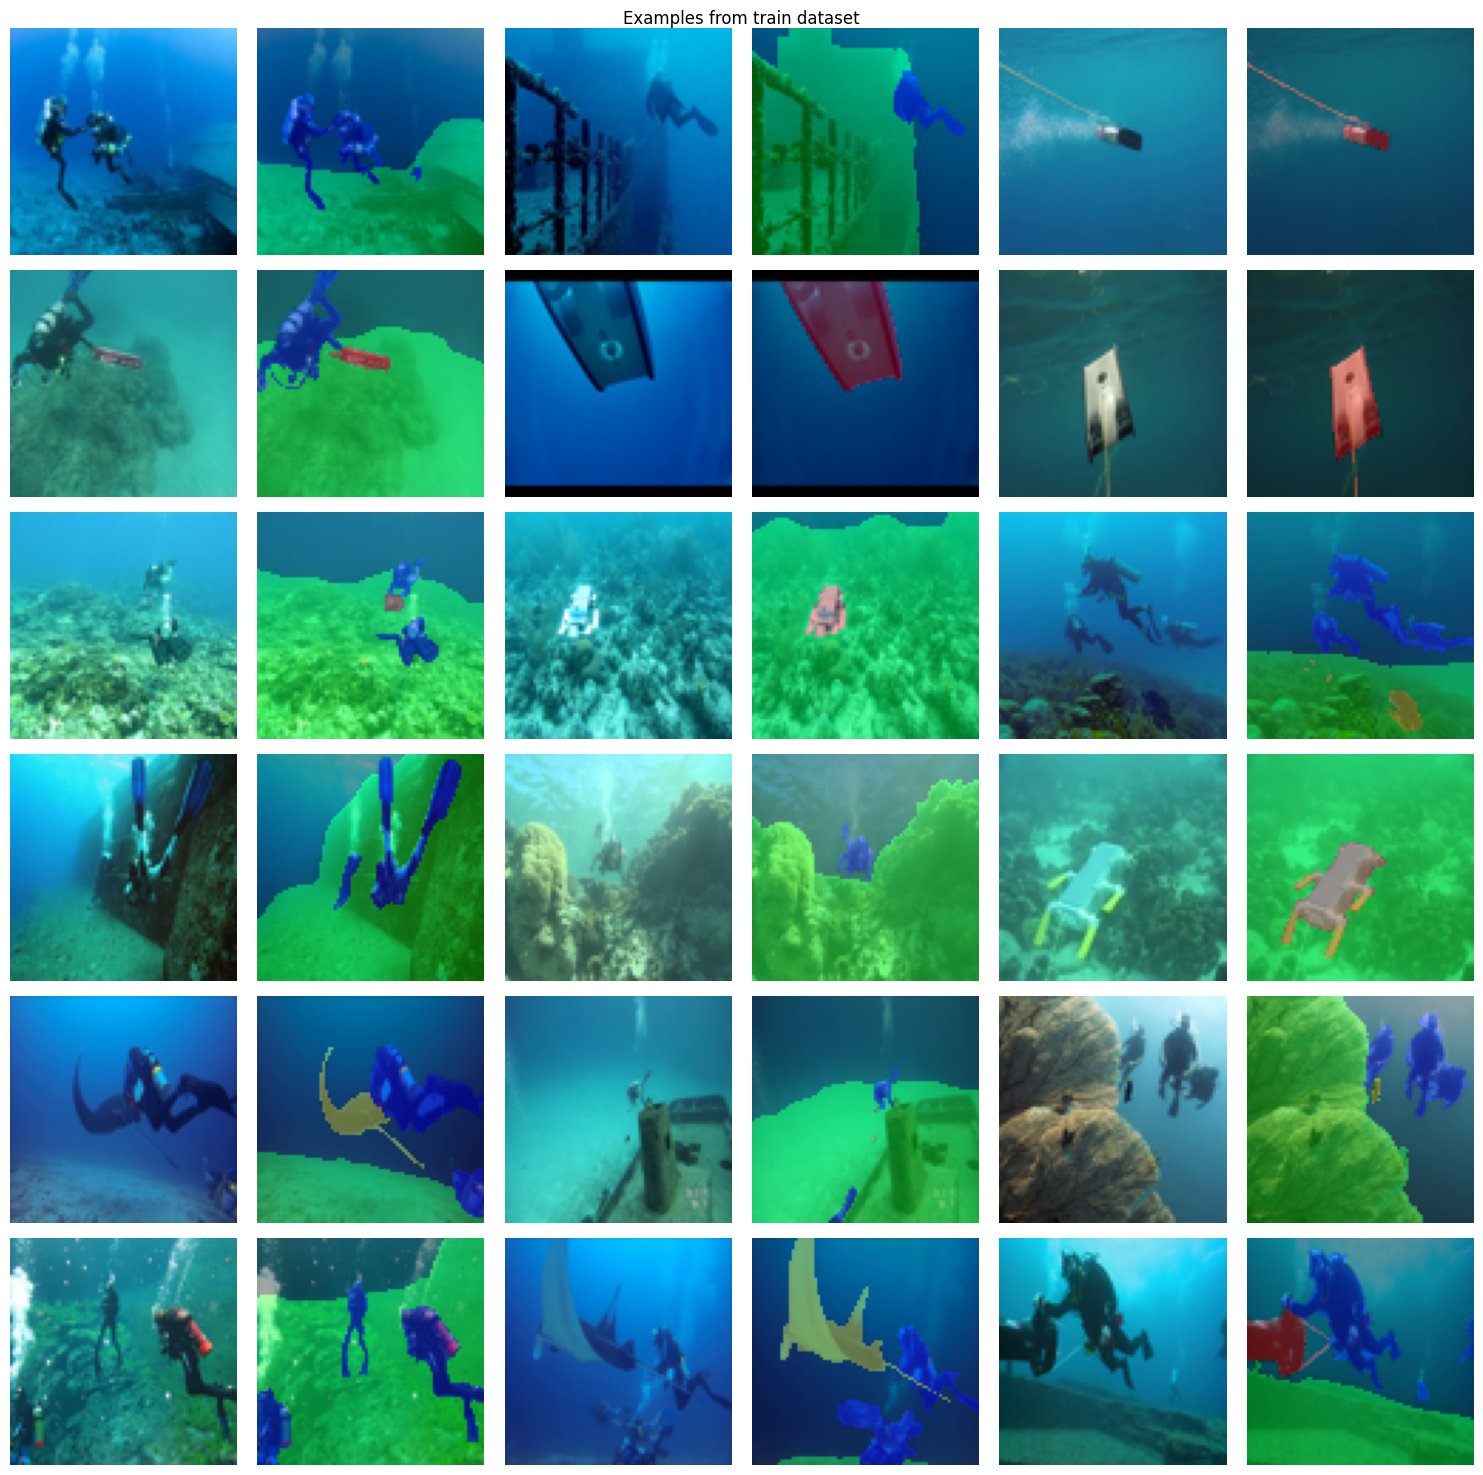

In [ ]:
plot_images_with_masks(train_dataset, 'Examples from train dataset')

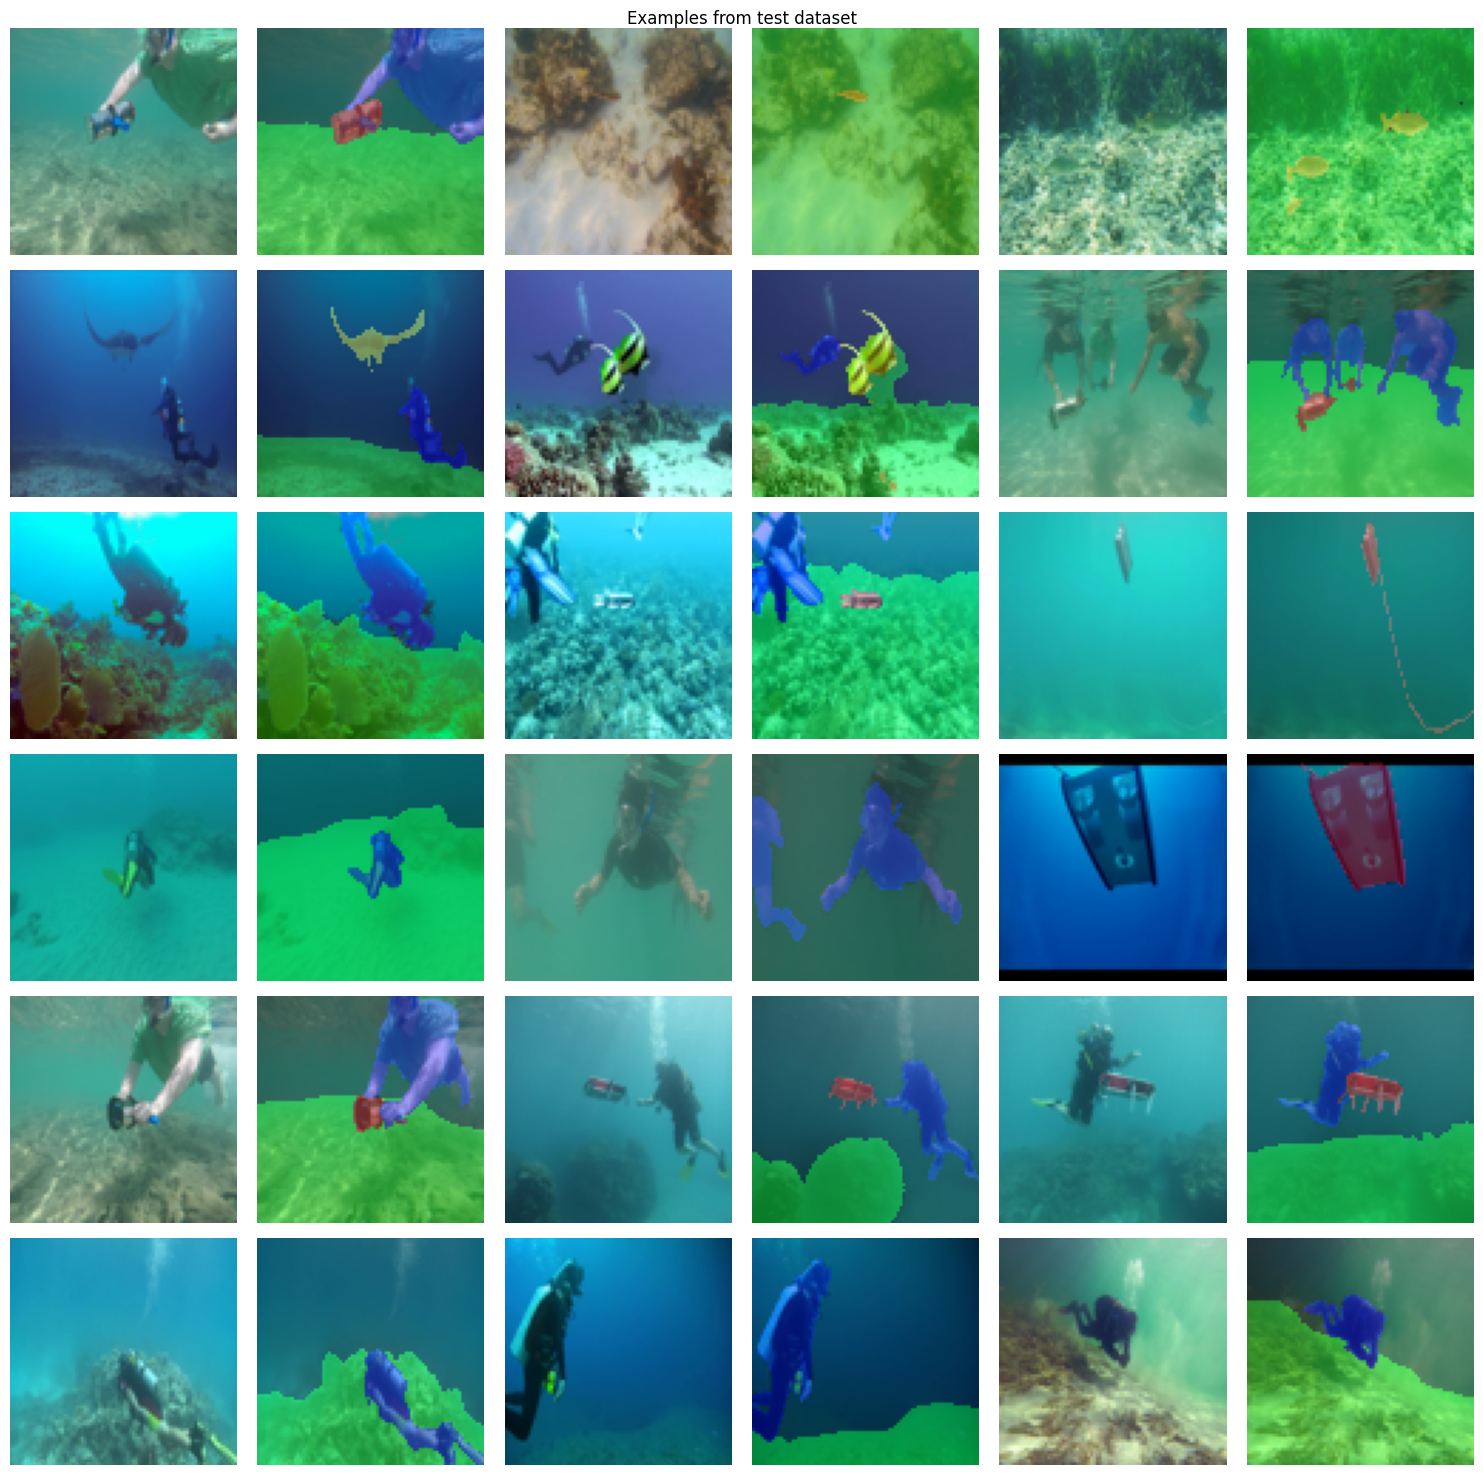

In [98]:
plot_images_with_masks(test_dataset, 'Examples from test dataset')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda


#### Эксперименты

Гиперпараметры обучения

In [99]:
learning_rate = 0.01
epochs = 80
batch_size = 36

Разбиение датасетов на батчи

In [100]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [101]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.25),
            #nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 'same'),
            #nn.BatchNorm2d(out_channels),
            #nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.max_pool(x)
        return self.conv(x)


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim = 1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels = 3, n_classes = 5):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DownSample(64, 128)
        self.down2 = DownSample(128, 256)
        self.down3 = DownSample(256, 512)
        self.dropout = nn.Dropout(0.5)
        self.down4 = DownSample(512, 1024)

        self.up1 = UpSample(1024 + 512, 512)
        self.up2 = UpSample(512 + 256, 256)
        self.up3 = UpSample(256 + 128, 128)
        self.up4 = UpSample(128 + 64, 64)

        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.dropout(x4)
        x6 = self.down4(x5)
        x = self.dropout(x6)

        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return torch.sigmoid(logits)

In [145]:
net = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
summary(net, (3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]           1,792
       BatchNorm2d-2           [-1, 64, 80, 80]             128
              ReLU-3           [-1, 64, 80, 80]               0
           Dropout-4           [-1, 64, 80, 80]               0
        DoubleConv-5           [-1, 64, 80, 80]               0
         MaxPool2d-6           [-1, 64, 40, 40]               0
            Conv2d-7          [-1, 128, 40, 40]          73,856
       BatchNorm2d-8          [-1, 128, 40, 40]             256
              ReLU-9          [-1, 128, 40, 40]               0
          Dropout-10          [-1, 128, 40, 40]               0
       DoubleConv-11          [-1, 128, 40, 40]               0
       DownSample-12          [-1, 128, 40, 40]               0
        MaxPool2d-13          [-1, 128, 20, 20]               0
           Conv2d-14          [-1, 256,

In [103]:
for epoch in range(epochs):
    loss_list = []
    time_one = time.time()
    for data in train_loader:
        images = data[0].permute(0, 3, 1, 2).to(device)
        labels = data[1].permute(0, 3, 1, 2).to(device)

        outputs = net(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)

    diff_time = time.time() - time_one
    print(f"Epoch: {epoch + 1}/{epochs}, "
          f"Loss: {torch.stack(loss_list).mean():.4f}, "
          f"Time: {diff_time:.2f} ")

Epoch: 1/80, Loss: 0.3077, Time: 7.48 
Epoch: 2/80, Loss: 0.2391, Time: 7.38 
Epoch: 3/80, Loss: 0.2211, Time: 7.41 
Epoch: 4/80, Loss: 0.2108, Time: 7.45 
Epoch: 5/80, Loss: 0.2105, Time: 7.52 
Epoch: 6/80, Loss: 0.2019, Time: 7.51 
Epoch: 7/80, Loss: 0.2028, Time: 7.57 
Epoch: 8/80, Loss: 0.1961, Time: 7.58 
Epoch: 9/80, Loss: 0.1915, Time: 7.62 
Epoch: 10/80, Loss: 0.1883, Time: 7.64 
Epoch: 11/80, Loss: 0.1857, Time: 7.66 
Epoch: 12/80, Loss: 0.1825, Time: 7.67 
Epoch: 13/80, Loss: 0.1807, Time: 7.72 
Epoch: 14/80, Loss: 0.1779, Time: 7.69 
Epoch: 15/80, Loss: 0.1722, Time: 7.70 
Epoch: 16/80, Loss: 0.1699, Time: 7.76 
Epoch: 17/80, Loss: 0.1643, Time: 7.75 
Epoch: 18/80, Loss: 0.1650, Time: 7.77 
Epoch: 19/80, Loss: 0.1615, Time: 7.78 
Epoch: 20/80, Loss: 0.1578, Time: 7.81 
Epoch: 21/80, Loss: 0.1560, Time: 7.81 
Epoch: 22/80, Loss: 0.1531, Time: 7.82 
Epoch: 23/80, Loss: 0.1508, Time: 7.82 
Epoch: 24/80, Loss: 0.1558, Time: 7.83 
Epoch: 25/80, Loss: 0.1512, Time: 7.84 
Epoch: 26

Оценка Acc для классов: [0.931  0.983  0.9956 0.9385 0.9053]
Оценка IoU для классов: [0.8345 0.3665 0.2418 0.4949 0.8223]
Оценка Acc на данных: 0.9507
Оценка IoU на данных: 0.5518


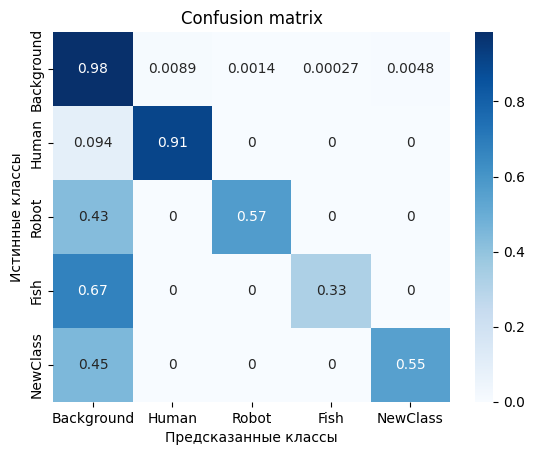

In [104]:
def IoU_bin(labels, predict):
    intersection = np.logical_and(labels, predict)
    union = np.logical_or(labels, predict)
    iou_score = np.sum(intersection) / (0.0001 + np.sum(union))
    return iou_score


def IoU_accuracy_cm_compute(X):
    accuracy_list, IoU_list = [], []
    cm_label, cm_pred = [], []
    with torch.no_grad():
        for images, labels in X:
            images = images.permute(0, 3, 1, 2).to(device)
            labels = labels.permute(0, 3, 1, 2).numpy()
            predict = net(images)
            predict = torch.where(predict < torch.tensor(0.5),
                                            torch.tensor(0),
                                            torch.tensor(1)).cpu().numpy()

            for elem in range(1, 6):
                elem = elem - 1
                labels_5_int = labels[:, elem, :, :]
                predict_5_int = predict[:, elem, :, :]

                labels_5_int = np.where(labels_5_int != 1, 0, elem + 1)
                predict_5_int = np.where(predict_5_int != 1, 0, elem + 1)
                labels[:, elem, :, :] = labels_5_int
                predict[:, elem, :, :] = predict_5_int

            cm_label.append(labels)
            cm_pred.append(predict)

            temp_acc, temp_iou = [], []
            for k in range(5):
                acc = np.mean(predict[:, k, :, :] == labels[:, k, :, :])
                IoU = IoU_bin(labels[:, k, :, :], predict[:, k, :, :])
                temp_acc.append(acc)
                temp_iou.append(IoU)
            accuracy_list.append(temp_acc)
            IoU_list.append(temp_iou)

    accuracy_list = np.array(accuracy_list)
    IoU_list = np.array(IoU_list)

    print(f'Оценка Acc для классов: {np.mean(accuracy_list, axis = 0, dtype = np.float16)}')
    print(f'Оценка IoU для классов: {np.mean(IoU_list, axis = 0, dtype = np.float16)}')

    print(f'Оценка Acc на данных: {np.mean(accuracy_list, dtype = np.float16):.4f}')
    print(f'Оценка IoU на данных: {np.mean(IoU_list, dtype = np.float16):.4f}')

    cm_label = np.concatenate(cm_label, axis = 0)
    cm_pred = np.concatenate(cm_pred, axis = 0)
    cm_label = cm_label.flatten()
    cm_pred = cm_pred.flatten()

    name_class = ['Background', 'Human', 'Robot', 'Fish', 'NewClass']
    cm = confusion_matrix(cm_label, cm_pred, labels = np.arange(5), normalize = 'true')
    sea.heatmap(cm, annot = True, cmap = 'Blues', xticklabels = name_class, yticklabels = name_class)
    plt.xlabel('Предсказанные классы')
    plt.ylabel('Истинные классы')
    plt.title('Confusion matrix')
    plt.show()

IoU_accuracy_cm_compute(test_loader)

In [140]:
def plot_images_with_masks_test(dataset):
    vert_size = 12
    horiz_size = 2
    fig, axes = plt.subplots(vert_size, horiz_size * 3, figsize = (15, 25))
    fig.suptitle("Predicted vs. True")

    mask_sizes = (image_size, image_size, 3)

    count_images = vert_size * horiz_size
    for number in range(count_images):
        i = number // horiz_size
        j = number % horiz_size

        image, mask = dataset[number]

        axes[i, j * 3].imshow(image, cmap=plt.cm.binary)
        axes[i, j * 3].set_title('Image', fontsize = 10)
        axes[i, j * 3].axis('off')

        with torch.no_grad():
            images = image
            images = images.unsqueeze(0)
            images = images.permute(0, 3, 1, 2).to(device)
            predict_mask = net(images)
            predict_mask = torch.where(predict_mask < torch.tensor(0.5), torch.tensor(0), torch.tensor(1)).permute(0, 2, 3, 1).cpu()

        rgb_predicted_mask = np.zeros(mask_sizes)
        for k in range(number_classes):
            rgb_predicted_mask[predict_mask[0, :, :, k] > 0] = color_classes[k]

        axes[i, j * 3 + 1].imshow(image, cmap=plt.cm.binary)
        axes[i, j * 3 + 1].imshow(rgb_predicted_mask, alpha = 0.35)
        axes[i, j * 3 + 1].set_title('Predicted', fontsize = 10)
        axes[i, j * 3 + 1].axis('off')

        rgb_mask = np.zeros(mask_sizes)
        for k in range(number_classes):
            rgb_mask[mask[:, :, k] > 0] = color_classes[k]

        axes[i, j * 3 + 2].imshow(image, cmap=plt.cm.binary)
        axes[i, j * 3 + 2].imshow(rgb_mask, alpha = 0.35)
        axes[i, j * 3 + 2].set_title('True', fontsize = 10)
        axes[i, j * 3 + 2].axis('off')

    plt.tight_layout()
    plt.show()

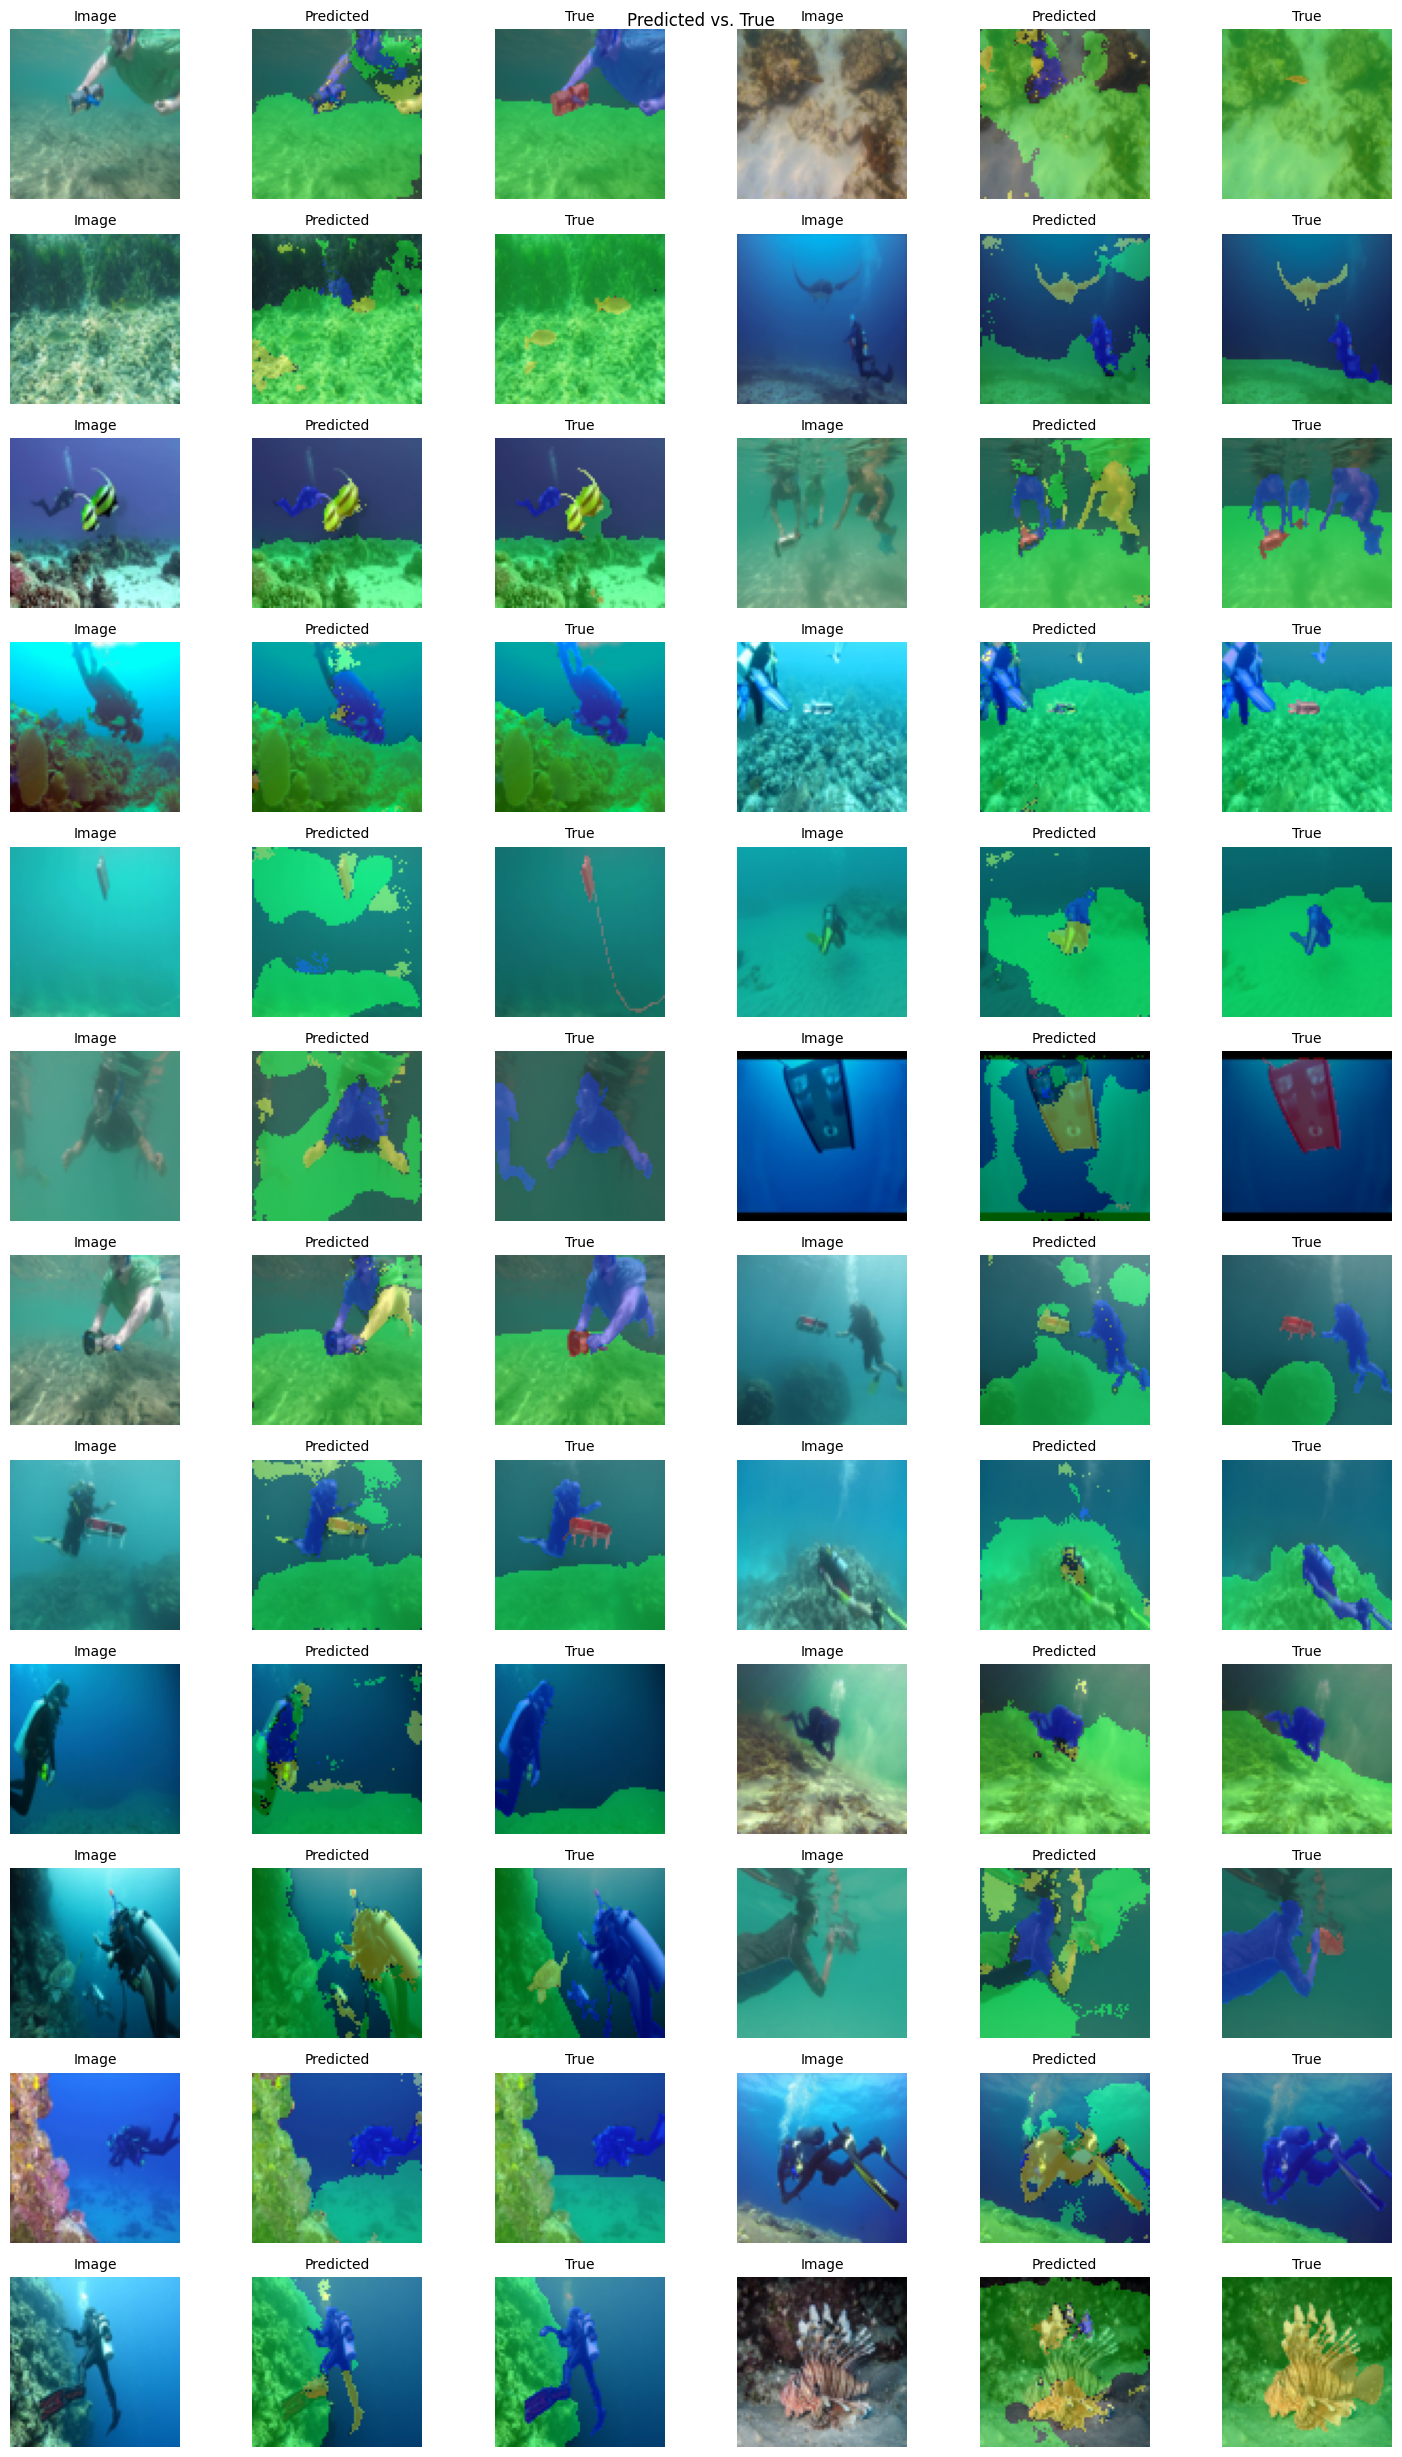

In [141]:
plot_images_with_masks_test(test_dataset)